In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.color
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

DATA_PATH = 'GeneratedData/test/'
IDS = np.loadtxt(DATA_PATH + '/Directory.txt').astype(int)

Using TensorFlow backend.


In [2]:
print("ids: " + str(IDS))

ids: [136724346 136724434 136724488 136724575 136724626 136724677 136724722
 136724759 136724808 136724856 136724910 136724952 136724984 136725025
 136725057 136725090 136725152 136725192 136725230 136725290 136725334
 136725363 136725400 136725443 136725484 136725520 136725556 136725604
 136725650 136725685 136725733 136725752 136725796 136725828 136725870
 136725925 136725965 136726017 136726065 136726122 136726175 136726250
 136726301 136726325 136726371 136726399 136726438 136726488 136726543
 136726594 136726713 136726746 136726784 136726812 136726843 136726898
 136726938 136726992 136727027 136727071 136727115 136727152 136727197
 136727236 136727292 136727314 136727368 136727400 136727439 136727470
 136727519 136727567 136727603 136727648 136727698 136727743 136727798
 136727836 136727864 136727908 136727961 136728013 136728055 136728102
 136728127 136728186 136728244 136728286 136728324 136728362 136728406
 136728435 136728490 136728533 136728581 136728628 136728671 136728726
 

## Configurations

In [4]:
class SonarConfig(Config):
    """
    Configuration for training on the sonar dataset.
    Derives from the base Config class and ovverrides values specific to the sonar dataset.
    """
    
    # Give configuration a recognizable name
    NAME = "sonar"

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number if classes (including background)
    NUM_CLASSES = 1 + 1    # background + target
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 320
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

config = SonarConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Pulls data from AcousticModel simulator that includes:

* `ImageMap-<id>`: 25 image planes with each being 64x64 image w/ value 0-255`
* `LabelMap-<id>`: single 64x64 image that is 1 or 0 for target or no target respectively across all planes

Extend the Dataset class and add a method to load the sonar dataset, `load_sonar_images()`, and override the following methods:

* `load_image()`
* `load_mask()`

In [6]:
class SonarDataset(utils.Dataset):
    
    def __init__(self, class_map=None):
        """Extend __init__ parent class"""
        
        super(SonarDataset, self).__init__(class_map)
        
        # Load image tag ids
        # TODO: more portable
        self.ids = IDS
        
        # Add data path
        # TODO: more portable
        self.data_path = DATA_PATH
    
    def load_sonar(self, mode, train_size):
        """Loads sonar images (w/ masks aka labels)"""
    
        # Add class
        self.add_class("sonar", 1, "target")
        
        # Calculate split
        subset = []
        split_index = int(train_size * len(self.ids))
        image_indeces = np.arange(len(self.ids))
        if mode == "train":
            subset = image_indeces[:split_index]
        elif mode == "test":
            subset = image_indeces[split_index:]
        else:
            print("Error: specify mode")
            
        # Add images (w/ masks)
        # TODO: more portable
        for _,image_index in enumerate(subset):
            
            # Get the id tagged to the image
            id = self.ids[image_index]
            
            # Note - since each input is 25x64x64 we reduce this to 320x320
            img = np.fromfile(DATA_PATH + 'ImageMap-' + str(id) + '.dat',
                       dtype='uint8')
            img.shape = (320, 320)
            
            # Convert image from [height, width] to [height, width, 3]
            img = skimage.color.gray2rgb(img)
            
            # Note - Match label dimensions with inputs by copying a 64x64 label side by side 
            #        into a 320x320 label
            mask = np.fromfile(DATA_PATH + 'LabelMap-' + str(id) + '.dat',
                       dtype='uint8')
            mask.shape = (64, 64)
            mask_ext = np.array(mask, copy=True)

            # Horizontal extension 
            for _ in range(int(320/64) - 1):
                mask_ext = np.hstack((mask_ext, mask))

            # Vertical extension
            horz_copy = np.array(mask_ext, copy=True)
            for _ in range(int(320/64) - 1):
                mask_ext = np.vstack((mask_ext, horz_copy))
            
            # Convert to bool array and reshape for desired output
            # TODO: fix hardcode
            mask = mask_ext.astype(np.bool).reshape((320,320,1))
            
            # Number of instances in label (only target)
            # TODO: fix hardcode
            class_ids = np.array([1])
            
            # Add image
            self.add_image("sonar", image_id=id, path=None, width=320, height=320, 
                           image=img, mask=mask, class_ids=class_ids)
    
    def load_image(self, image_id):
        """
        Load the image specified by `image_id` in 3 color channels
        
        Return:
            image: shape [height, width, 3]
        """
        
        return self.image_info[image_id]["image"]
    
    def load_mask(self, image_id):
        """
        Load the sonar detection mask for the given image.
        Note - Since there is only 1 class (i.e target), will only return a label
               with 1 instance and class_id.
        Returns:
            mask: A bool array of shape [height, width, instance count] with a
                    a binary label per instance.
                    
            class_id: a 1D array of IDs of the instance labels.    
        """
        # Get mask and class_ids that matches `image_id`
        mask = self.image_info[image_id]["mask"]                
        class_ids = self.image_info[image_id]["class_ids"]
        
        return mask, class_ids

In [7]:
# Train/Test split: ~ 0.75/0.25
split = 0.75

# Training dataset
dataset_train = SonarDataset()
dataset_train.load_sonar("train", train_size=split)
dataset_train.prepare()

# Testing dataset
dataset_test = SonarDataset()
dataset_test.load_sonar("test", train_size=split)
dataset_test.prepare()

In [9]:
# Show train and test ids
print("Train ids: ", end="")
for item in dataset_train.image_info:
    print(item["id"], end=" ")

print("\n")

print("Test ids: ", end="")
for item in dataset_test.image_info:
    print(item["id"], end=" ")

Train ids: 136724346 136724434 136724488 136724575 136724626 136724677 136724722 136724759 136724808 136724856 136724910 136724952 136724984 136725025 136725057 136725090 136725152 136725192 136725230 136725290 136725334 136725363 136725400 136725443 136725484 136725520 136725556 136725604 136725650 136725685 136725733 136725752 136725796 136725828 136725870 136725925 136725965 136726017 136726065 136726122 136726175 136726250 136726301 136726325 136726371 136726399 136726438 136726488 136726543 136726594 136726713 136726746 136726784 136726812 136726843 136726898 136726938 136726992 136727027 136727071 136727115 136727152 136727197 136727236 136727292 136727314 136727368 136727400 136727439 136727470 136727519 136727567 136727603 136727648 136727698 

Test ids: 136727743 136727798 136727836 136727864 136727908 136727961 136728013 136728055 136728102 136728127 136728186 136728244 136728286 136728324 136728362 136728406 136728435 136728490 136728533 136728581 136728628 136728671 1367287

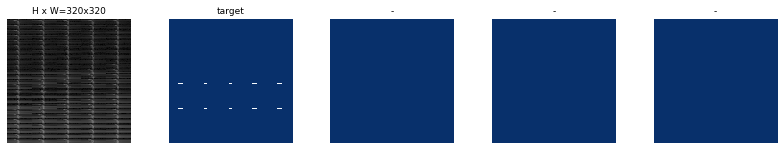

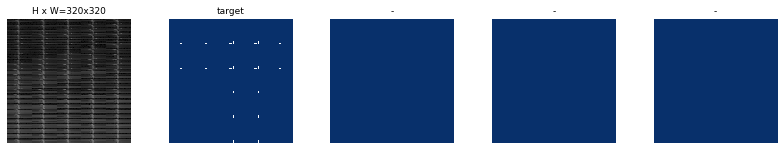

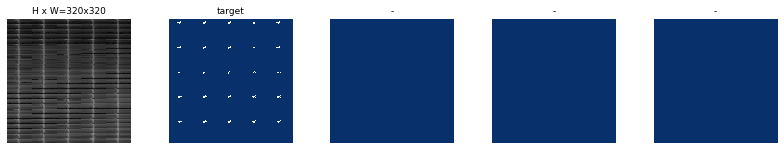

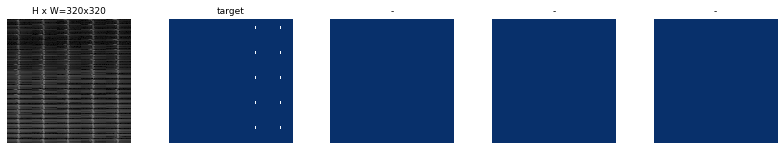

In [12]:
# Load and display train image and mask samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

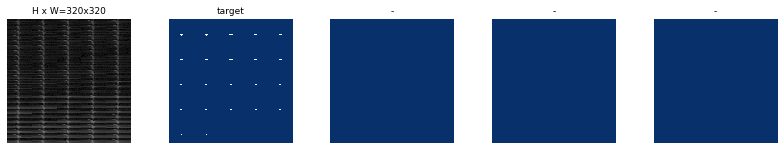

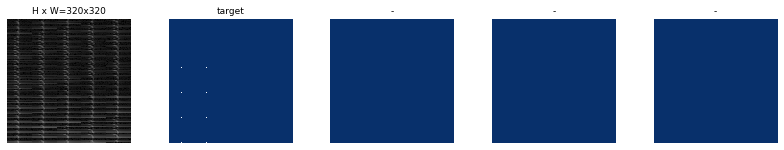

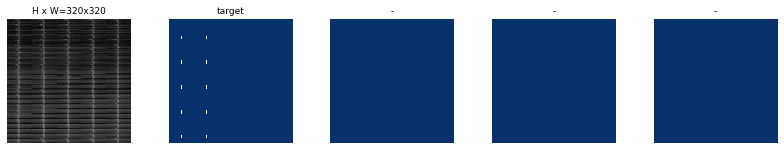

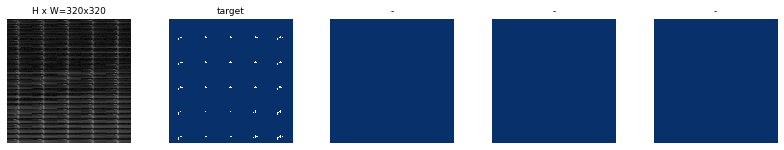

In [13]:
# Load and display test image and mask samples
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

## Create Model

In [14]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

W0725 13:41:33.140775 140089883297600 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 13:41:33.183968 140089883297600 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 13:41:33.216934 140089883297600 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 13:41:33.257383 140089883297600 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please us

In [15]:
# Load last model trained and continue training
# model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/admin/dev/SonarNet/logs/sonar20190725T1341/mask_rcnn_sonar_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

W0725 13:41:44.369621 140089883297600 deprecation_wrapper.py:119] From /home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a den

Epoch 1/1
100/100 [==============================] - 370s 4s/step - loss: 2.7512 - rpn_class_loss: 0.1509 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.8949 - mrcnn_mask_loss: 0.1699 - val_loss: 1.6673 - val_rpn_class_loss: 0.0436 - val_rpn_bbox_loss: 0.9853 - val_mrcnn_class_loss: 0.0072 - val_mrcnn_bbox_loss: 0.5574 - val_mrcnn_mask_loss: 0.0737


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_test, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/admin/dev/SonarNet/logs/sonar20190725T1341/mask_rcnn_sonar_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bra

/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/admin/anaconda3/envs/ml/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWa

Epoch 2/2
 18/100 [====>.........................] - ETA: 11:43 - loss: 0.6274 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.2558 - mrcnn_mask_loss: 0.0566

## Detection

In [ ]:
class InferenceConfig(SonarConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

## Evaluation

---

## Test code

In [ ]:
# Input: 25 input image planes of size 64 x 64
# Label: 1 label image of size 64 x 64
# Retrieve all input and label images
inputs, labels = [], []
test_image_info = []
for id in IDS:    
    x = np.fromfile(DATA_PATH + 'ImageMap-' + str(id) + '.dat',
                       dtype='uint8').astype(float)
    x.shape = (25, 64, 64)
    inputs.append(x)
    test_image_info.append({"id":id, "source":"sonar", "path":None, "image":x})

    y = np.fromfile(DATA_PATH + 'LabelMap-' + str(id) + '.dat',
                       dtype='uint8').astype(float)
    y.shape = (64, 64)
    labels.append(y)

inputs = np.array(inputs)
labels = np.array(labels)

img_obj = next(item for item in test_image_info if item["id"] == 84384008)
img_obj["image"]

In [ ]:
# Display example slice
# Input: 25 slices of sonar beam
s = 3
for i in range(25):
    plt.imshow(inputs[s,i,:,:])
    plt.show()

In [ ]:
# Label: target detection
plt.imshow(labels[s])

In [ ]:
# Reduce dimensionality from 25x64x64 to 320x320
test = np.reshape(inputs[s], (320,320))

plt.imshow(test)
plt.show()

In [ ]:
# Match label dimensions with inputs by copying a 64x64 label side by side into a 320x320 label
test_label = np.array(labels[s], copy=True)

# Horizontal copy 
for _ in range(int(320/64) - 1):
    test_label = np.hstack((test_label, labels[s]))

# Vertical copy
horz_copy = np.array(test_label, copy=True)
for _ in range(int(320/64) - 1):
    test_label = np.vstack((test_label, horz_copy))

plt.imshow(test_label)
# Test that each image is the same
# for row in range(5):
#     for col in range(5):
#         plt.figure()
#         plt.imshow(test_label[row*64:row*64+64-1, col*64:col*64+64-1])
#         plt.title("(i,j): (%i, %i)" % (col, row))
#         plt.show

---

Credit:

[1] https://github.com/matterport/Mask_RCNN/samples/shapes/train_shapes.ipynb
